In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
%matplotlib inline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import feature_selection as fs
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('epi_r.csv') as f:
    df = pd.read_csv(f)

In [4]:
df.shape

(20052, 680)

### Задача: обучить модель предсказывать рэйтинг блюда

Необходимо сделать следующие шаги:

1) Сделать что-то с пропусками(выбросить или заполнить чем либо)

2) Сделать что-то с дубликатами

3) Проверсти препроцессинг(выделить факторы, нормальзовать факторы)

4) Попробовать добваить новые факторы на основе имеющихся

5) Обучить модель и проверить результаты на тестовой выборке(изначально нужно разделить на тестовыю и обучающуюся)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


#### Из описания видно, что только один столбец содержит в себе строки, а остальные столбцы - числа

In [6]:
df.describe()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.000299,0.000050,0.000848,0.001346,0.000349,...,0.001247,0.026332,0.000050,0.000299,0.014861,0.000150,0.000349,0.001396,0.000948,0.022741
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.017296,0.007062,0.029105,0.036671,0.018681,...,0.035288,0.160123,0.007062,0.017296,0.121001,0.012231,0.018681,0.037343,0.030768,0.149080
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.isna().sum().sort_values()[-4:]

calories    4117
sodium      4119
protein     4162
fat         4183
dtype: int64

In [8]:
sum(df.isna().sum() > 0)

4

#### calories, protein, fat, sodium -  имеют пропущенные значения

In [9]:
df_clear = df.drop_duplicates().dropna()

### Определим выбросы

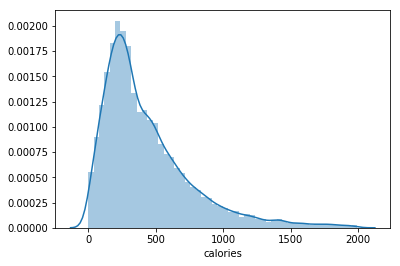

In [10]:
sns.distplot(df_clear.calories[df_clear.calories < 2000].dropna())

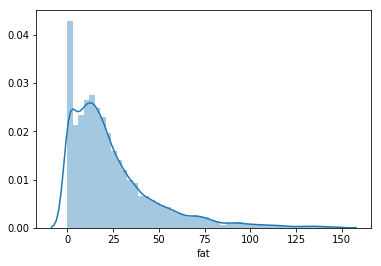

In [11]:
sns.distplot(df_clear.fat[df_clear.fat < 150].dropna())

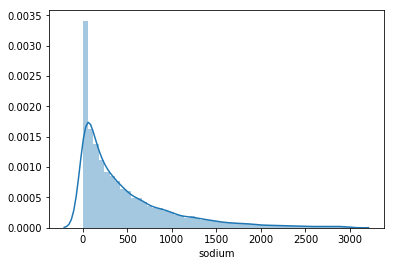

In [12]:
sns.distplot(df_clear.sodium[df_clear.sodium < 3000].dropna())

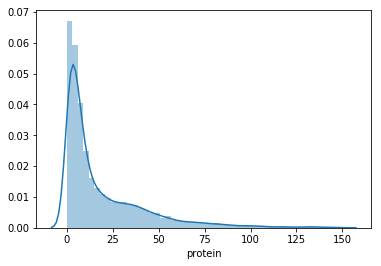

In [13]:
sns.distplot(df_clear.protein[df_clear.protein < 150].dropna())

Выпишем границу для каждой колонки, значения выше которой мы будем принимать за выбросы

In [14]:
treshholds = [
    ('calories', 2000),
    ('sodium', 3000),
    ('fat', 150),
    ('protein', 150)
]

Удалим выбросы

In [15]:
for col, val in treshholds:
    df_clear = df_clear[df_clear[col] < val]

In [16]:
df_clear.shape

(13786, 680)

Удалим название блюд, так как они не несут полезной информации

In [17]:
df_clear = df_clear.drop('title', axis=1)

In [18]:
df_train, df_test = model_selection.train_test_split(df_clear)

In [19]:
df_train.shape, df_test.shape

((10339, 679), (3447, 679))

In [20]:
# Заполним все Nan средним значением по каждой колонке
# df_train = df_train.fillna(df_train.mean())
# df_test = df_test.fillna(df_test.mean())

In [21]:
X_train = df_train.drop('rating', axis=1)
y_train = df_train.rating

X_test = df_test.drop('rating', axis=1)
y_test = df_test.rating

In [22]:
lr = linear_model.LinearRegression()
lr.fit(X_train.values, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
metrics.mean_absolute_error(y_train, lr.predict(X_train))

0.7496090419977322

In [24]:
metrics.mean_absolute_error(y_test, lr.predict(X_test))

37483.21839950008

Видим, что ошибка на тестовой выборке на несколько порядков выше. Это говорит нам о переобучении модели

In [69]:
from sklearn import feature_selection

In [68]:
print(X_train_norm.shape)
print(feature_selection.VarianceThreshold(.10).fit_transform(X_train_norm).shape)

(10339, 678)
(10339, 644)


In [27]:
VT = feature_selection.VarianceThreshold(.01).fit(X_train)

In [28]:
X_train_vt = VT.transform(X_train)
X_test_vt = VT.transform(X_test)
X_test_vt.shape

(3447, 207)

In [47]:
metrics.mean_absolute_error(y_train, lr1.predict(X_norm_tr))

0.7899975851368403

In [48]:
metrics.mean_absolute_error(y_test, lr1.predict(X_norm_ts))

0.8199764806750521

In [54]:
scaler = preprocessing.StandardScaler()

In [55]:
scaler.fit(df_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [56]:
df_norm_tr = scaler.transform(df_train)
df_norm_ts = scaler.transform(df_test)

In [58]:
df_norm_tr[:,-1:]

array([[-0.12537399],
       [-0.12537399],
       [-0.12537399],
       ...,
       [-0.12537399],
       [-0.12537399],
       [-0.12537399]])

In [61]:
X_train_norm = df_norm_tr[:,:-1]
y_train_norm = df_norm_tr[:,-1:]

X_test_norm = df_norm_ts[:,:-1]
y_test_norm = df_norm_ts[:,-1:]

In [62]:
lr1 = linear_model.LinearRegression()
lr1.fit(X_train_norm, y_train_norm )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [63]:
metrics.mean_absolute_error(y_train_norm, lr1.predict(X_train_norm))

0.3885416205757484

In [64]:
metrics.mean_absolute_error(y_test_norm, lr1.predict(X_test_norm))

37333835775.866035

Переобучение значительно сократилось, но все же присутсвует

In [49]:
all_losses = []

for k in range(5, 208, 3):
    X_kbest = feature_selection.SelectKBest(
        feature_selection.f_classif, 
        k=k,
    ).fit_transform(
        X_norm_tr,
        y_train,
    )
    lr = linear_model.LinearRegression()
    standart_scaler = preprocessing.StandardScaler()
    loss = model_selection.cross_val_score(
        lr, 
        standart_scaler.fit_transform(X_kbest),
        y_train, 
        scoring='neg_mean_absolute_error'
    ).mean()
    print(f"k = {k} neg_mean_absolute_error = {loss}")
    all_losses.append(loss)

k = 5 neg_mean_absolute_error = -0.8027713672129915
k = 8 neg_mean_absolute_error = -0.7972236652621026
k = 11 neg_mean_absolute_error = -0.802416246403408
k = 14 neg_mean_absolute_error = -0.8054122220059877
k = 17 neg_mean_absolute_error = -0.806542553237476
k = 20 neg_mean_absolute_error = -0.8066234787164198
k = 23 neg_mean_absolute_error = -0.8060052746848712
k = 26 neg_mean_absolute_error = -0.8055539663541614
k = 29 neg_mean_absolute_error = -0.8059421943229754
k = 32 neg_mean_absolute_error = -0.8063607359158645
k = 35 neg_mean_absolute_error = -0.8057425804102637
k = 38 neg_mean_absolute_error = -0.8043984944616446
k = 41 neg_mean_absolute_error = -0.8050449339509996
k = 44 neg_mean_absolute_error = -0.8043830024858889
k = 47 neg_mean_absolute_error = -0.8047149331160085
k = 50 neg_mean_absolute_error = -0.8037776738868136
k = 53 neg_mean_absolute_error = -0.8040929448998884
k = 56 neg_mean_absolute_error = -0.8040818000982849
k = 59 neg_mean_absolute_error = -0.80433303412932

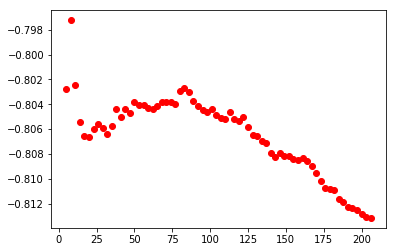

In [50]:
plt.plot(range(5, 208, 3), all_losses, 'ro')
plt.show()

In [38]:
kbest = feature_selection.SelectKBest(
        feature_selection.f_classif, 
        k=8,
    ).fit(
        X_norm_tr,
        y_train,
    )

In [51]:
X_kbest_tr = kbest.transform(X_norm_tr)
X_kbest_ts = kbest.transform(X_norm_ts)

In [52]:
loss = model_selection.cross_val_score(
    linear_model.LinearRegression(), 
    X_kbest_tr,
    y_train, 
    scoring='neg_mean_absolute_error'
).mean()
print("k =", 8, "neg_mean_absolute_error =", loss)

k = 8 neg_mean_absolute_error = -0.7972236652621026


In [53]:
loss = model_selection.cross_val_score(
    linear_model.LinearRegression(), 
    X_kbest_ts,
    y_test, 
    scoring='neg_mean_absolute_error'
).mean()
print("k =", 8, "neg_mean_absolute_error =", loss)

k = 8 neg_mean_absolute_error = -0.8174828748469428
